## Information Leakage

Data:
1. Generate Data
    - y ~ normal (mean =0, std=1,n=100)
    - x ~ normal (mean =0,std=1,n=100, dimension =10000)
    - Y and X uncorrelated each other (no relationship)
2. Information Leakage
    - Modeling X and y using ridge + percentile feature selection (f statistics)
    - Do feature selection : apply fit and transform to x
    - Compute R-Square using cross validation
3. No Information Lakage
    - Modeling x and y using ridge + percentile feature selection (f statistics)
    - Make pipeline : feature selection + regression
    - Compute R-square using cross validation

In [1]:
import pandas as pd
import numpy as np

In [2]:
rnd = np.random.RandomState(seed = 2020)
x= rnd.normal(size=(100,10000))
y=rnd.normal(size=(100,1))

### Information Leakage

In [3]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [4]:
select = SelectPercentile(score_func=f_regression, percentile=5)
x_selected = select.fit_transform(x,y)
x_selected.shape

C:\Users\62812\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(100, 500)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [6]:
cross_val_score(Ridge(), x_selected, y, cv=5)

array([0.92165345, 0.89445668, 0.92827414, 0.93088559, 0.91044624])

### No Information Leakage

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
select = SelectPercentile(score_func=f_regression, percentile=5)
pipe_ridge = Pipeline([
    ('select',select),
    ('model', Ridge())
])

In [9]:
cross_val_score(pipe_ridge, x, y, cv=5)

C:\Users\62812\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\62812\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\62812\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\62812\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

array([-0.0330359 , -0.07840338, -0.06731106, -0.04544685, -0.07314928])

## Apply Several Preprocessing Method to Modeling at once and do hyperparameter Tuning

data : adult.csv
target : income

preprocessing:
1. Missing value: simple imputer with constant
2. One hot encoding : realtionship, race, sex
3. Binary encoding : workclass, marital status, occupation, native country,
4. Ordinal encoding L education (already encoded)
5. No treatment : numerical
6. Out :fnlwgt

random state 10, data splitting 70:30
1. Model Tree (max depth 5, criterion entropy) and compute f1 using CV
2. Compute another metrics
3. Model Logistic Regression (solver liblinear) compute recall +, precision +, f1, make ROC and PRC in test set
4. Do hyperparameter tuning for logistic regression (optimize C and solver)
5. Compare the result (before and after) in test set

In [10]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report,plot_precision_recall_curve ,plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [11]:
df_adult = pd.read_csv('data/adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [12]:
df_adult['workclass'].unique()

array(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

### EDA

In [13]:
df_adult.isin(['?']).sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

### Preprocessing

In [14]:
onehot = OneHotEncoder(drop='first')

binary = Pipeline([
    ('imputer', SimpleImputer(missing_values=['?'],strategy='constant', fill_value='Others')),
    ('binary', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('onehot',onehot, ['relationship','race','sex']),
    ('binary', binary,['workclass','marital.status','occupation','native.country'])
], remainder='passthrough')

### Split Data

In [15]:
x = df_adult.drop(columns=['fnlwgt','income','education'])
y = np.where(df_adult['income']=='>50K',1,0)

In [16]:
x

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,?,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,?,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States
32557,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32558,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32559,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


In [17]:
x_trainval, x_val, y_trainval, y_val= train_test_split(
    x,
    y,
    stratify= y,
    test_size=0.3,
    random_state = 10
)

### Model Benchmark

In [18]:
skfold = StratifiedKFold(n_splits=5)
tree = DecisionTreeClassifier(max_depth=5,criterion='entropy', random_state=10)

estimator = Pipeline([
    ('transformer',transformer),
    ('model',tree)
])

In [19]:
tree_cv = cross_val_score(estimator, x_trainval, y_trainval, scoring='f1')

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders

In [20]:
print('hasil cross val', tree_cv)
print('cv score mean', tree_cv.mean())
print('cv score std', tree_cv.std())

hasil cross val [0.6226106  0.61480281 0.58849558 0.58738135 0.62121212]
cv score mean 0.6069004904458388
cv score std 0.015708688769425674


### ------------------------------------------------------------------------------------------------

In [21]:
skfold_2 = StratifiedKFold(n_splits=5)
logreg = LogisticRegression(solver='liblinear', random_state=10)

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

In [22]:
logreg_cv = cross_val_score(estimator, x_trainval, y_trainval, scoring='f1')
print('logreg', logreg_cv, 'mean', logreg_cv.mean(),'std', logreg_cv)

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders

logreg [0.63710499 0.63971341 0.62670873 0.64368981 0.65018032] mean 0.6394794525685199 std [0.63710499 0.63971341 0.62670873 0.64368981 0.65018032]


In [23]:
logreg_cv = cross_val_score(estimator, x_trainval, y_trainval, scoring='recall')
print('logreg', logreg_cv, 'mean', logreg_cv.mean(),'std', logreg_cv)

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


logreg [0.56921676 0.56921676 0.54329991 0.57832423 0.57468124] mean 0.5669477777611736 std [0.56921676 0.56921676 0.54329991 0.57832423 0.57468124]


C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [24]:
logreg_cv = cross_val_score(estimator, x_trainval, y_trainval, scoring='precision')
print('logreg', logreg_cv, 'mean', logreg_cv.mean(),'std', logreg_cv)

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\62812\anaconda3\lib\site-packages\category_encoders

logreg [0.72337963 0.73014019 0.74037267 0.72571429 0.7485172 ] mean 0.7336247947083504 std [0.72337963 0.73014019 0.74037267 0.72571429 0.7485172 ]


In [25]:
logreg = LogisticRegression(solver='liblinear',random_state=10)

estimator = Pipeline([
    ('transformer',transformer),
    ('model', logreg)
])

In [26]:
estimator.fit(x_trainval,y_trainval)

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 missing_values=['?'],
                                                                                 strategy='constant')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                       

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    x_trainval,
    y_trainval,
    test_size=0.3
    
)

y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5216
           1       0.71      0.57      0.64      1622

    accuracy                           0.84      6838
   macro avg       0.79      0.75      0.77      6838
weighted avg       0.84      0.84      0.84      6838



In [28]:
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5216
           1       0.71      0.57      0.64      1622

    accuracy                           0.84      6838
   macro avg       0.79      0.75      0.77      6838
weighted avg       0.84      0.84      0.84      6838



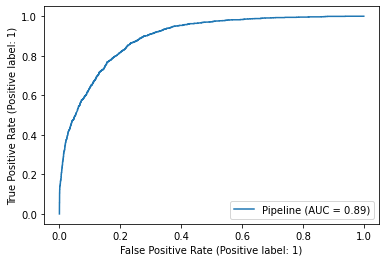

In [29]:
plot_roc_curve(estimator, x_test, y_test)

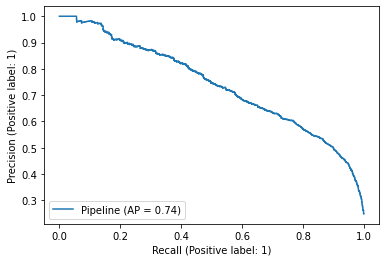

In [30]:
plot_precision_recall_curve(estimator,x_test, y_test)

### ------------------------------------------------------------------------------------------------

### Hyperparameter Tuning

In [31]:
# x_train, x_test, y_train, y_test = train_test_split(
#     x_trainval,
#     y_trainval,
#     stratify=y,
#     test_size=0.3,
#     random_state=2020
# )

In [32]:
logreg = LogisticRegression(solver='liblinear')

estimator = Pipeline([
    ('transformer',transformer),
    ('model',logreg)
])

hyperparam_c = {
    'model__C' : [100,10,1,0.1,0.001,0.0001],
    'model__solver':['liblinear', 'newton-cg']
}

skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid= hyperparam_c,
    cv=skfold,
    scoring ='f1',
    n_jobs=-1
)

In [33]:
# best = 0
# score =[]

# for i in hyperparam_c:
#     logreg = LogisticRegression(solver='liblinear', C=i)
#     logreg.fit(x_train,y_train)
    
#     y_pred = logreg.predict(x_val)
#     score = f1_score(y_val,y_pred)
    
#     if score > best:
#         best = score
#         best_param = i

grid_search.fit(x_train, y_train)

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='Others',
                                  

In [34]:
grid_search.best_params_

{'model__C': 1, 'model__solver': 'newton-cg'}

In [35]:
grid_search.best_score_

0.6534847551190621

In [36]:
hasil_cv = pd.DataFrame(grid_search.cv_results_)
hasil_cv.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.250083,0.160434,0.048652,0.003514,1,newton-cg,"{'model__C': 1, 'model__solver': 'newton-cg'}",0.692470,0.673568,0.623094,0.652015,0.626277,0.653485,0.026793,1
3,2.870065,0.097370,0.043790,0.000750,10,newton-cg,"{'model__C': 10, 'model__solver': 'newton-cg'}",0.695713,0.672188,0.618736,0.651061,0.627365,0.653013,0.028381,2
1,4.030091,0.361695,0.046066,0.002212,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.695713,0.672188,0.618736,0.650073,0.627365,0.652815,0.028398,3
7,2.092327,0.126027,0.055118,0.006876,0.1,newton-cg,"{'model__C': 0.1, 'model__solver': 'newton-cg'}",0.692090,0.670825,0.618315,0.650442,0.626010,0.651537,0.027470,4
0,0.455887,0.005598,0.045999,0.004393,100,liblinear,"{'model__C': 100, 'model__solver': 'liblinear'}",0.685915,0.653766,0.619841,0.652367,0.632565,0.648891,0.022437,5
4,0.440929,0.016119,0.048694,0.002283,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.688339,0.654219,0.620640,0.645542,0.623624,0.646473,0.024507,6
6,0.439431,0.026054,0.046478,0.001249,0.1,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.676746,0.661982,0.611193,0.652335,0.624362,0.645323,0.024159,7
2,0.440944,0.023937,0.045507,0.001917,10,liblinear,"{'model__C': 10, 'model__solver': 'liblinear'}",0.685915,0.652864,0.620290,0.643764,0.621444,0.644856,0.024095,8
9,1.837490,0.261732,0.074242,0.009209,0.001,newton-cg,"{'model__C': 0.001, 'model__solver': 'newton-cg'}",0.625197,0.578783,0.504202,0.560656,0.575586,0.568885,0.038899,9
11,1.488247,0.046516,0.045174,0.013168,0.0001,newton-cg,"{'model__C': 0.0001, 'model__solver': 'newton-...",0.520000,0.490956,0.412844,0.438061,0.468891,0.466150,0.037824,10


In [37]:
hasil_cv[(hasil_cv['param_model__C']==1) & (hasil_cv['param_model__solver']=='liblinear')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.440929,0.016119,0.048694,0.002283,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.688339,0.654219,0.62064,0.645542,0.623624,0.646473,0.024507,6


In [38]:
hasil_cv[(hasil_cv['param_model__C']==100) & (hasil_cv['param_model__solver']=='newton-cg')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,4.030091,0.361695,0.046066,0.002212,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.695713,0.672188,0.618736,0.650073,0.627365,0.652815,0.028398,3


### Perbandingan sebelum dan sesuah

In [39]:
# Before
logreg = LogisticRegression(solver='liblinear')

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

estimator.fit(x_train,y_train)

y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5216
           1       0.70      0.56      0.62      1622

    accuracy                           0.84      6838
   macro avg       0.79      0.74      0.76      6838
weighted avg       0.83      0.84      0.83      6838



In [40]:
# after
estimator = grid_search.best_estimator_
estimator.fit(x_train,y_train)
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

C:\Users\62812\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5216
           1       0.71      0.57      0.63      1622

    accuracy                           0.84      6838
   macro avg       0.79      0.75      0.77      6838
weighted avg       0.83      0.84      0.84      6838

